In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier

## 1. Реализация класса LogReg с автоматическим добавлением фиктивного столбца

In [28]:
class SGD:
    def __init__(self, alpha=0.5, n_iters=1000):
        self.b = None
        self._alpha = alpha
        self._n_iters = n_iters

    def gradient_step(self, b, b_grad):
        return b - self._alpha * b_grad

    def optimize(self, X, y, start_b, n_iters):
        b = start_b.copy()
        for i in range(n_iters):
            b_grad = self.grad_func(X, y, b)
            b = self.gradient_step(b, b_grad)
        return b

class LogReg(SGD):
    def __init__(self, alpha=0.1, n_iters=1000, add_intercept=True):
        super().__init__(alpha, n_iters)
        self.add_intercept = add_intercept
        
    def sigmoid(self, X, b):
        return 1. / (1. + np.exp(-X.dot(b)))
    
    def grad_func(self, X, y, b):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, b) - y)
        return grad
    
    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def fit(self, X, y):
        if self.add_intercept:
            X = self._add_intercept(X)
        self.b = self.optimize(X, y, np.zeros(X.shape[1]), self._n_iters)
    
    def predict_proba(self, X):
        if self.add_intercept:
            X = self._add_intercept(X)
        return self.sigmoid(X, self.b)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

## 2. Генерация данных и тестирование разных learning rates

In [31]:
# Генерация данных
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                         n_redundant=0, n_classes=2, class_sep=2,
                         random_state=1)

# Тестирование разных learning rates
def test_learning_rates(X, y, rates=[0.001, 0.01, 0.1, 0.5, 1.0, 5.0]):
    for alpha in rates:
        try:
            model = LogReg(alpha=alpha, n_iters=1000)
            model.fit(X, y)
            y_pred = model.predict(X)
            acc = accuracy_score(y, y_pred)
            print(f"Learning rate: {alpha:.3f}, Accuracy: {acc:.4f}")
        except:
            print(f"Learning rate {alpha:.3f} causes divergence!")

print("Testing different learning rates:")
test_learning_rates(X, y)

Testing different learning rates:
Learning rate: 0.001, Accuracy: 0.9730
Learning rate: 0.010, Accuracy: 0.9760
Learning rate: 0.100, Accuracy: 0.9760
Learning rate: 0.500, Accuracy: 0.9760
Learning rate: 1.000, Accuracy: 0.9760
Learning rate: 5.000, Accuracy: 0.9760


## 3. Обучение и оценка моделей

In [34]:
# Обучение кастомной модели
custom_model = LogReg(alpha=0.1, n_iters=1000)
custom_model.fit(X, y)
y_pred_custom = custom_model.predict(X)

# Обучение sklearn модели
sklearn_model = LogisticRegression()
sklearn_model.fit(X, y)
y_pred_sklearn = sklearn_model.predict(X)

# Вывод метрик
print("\nCustom Model:")
print("Accuracy:", accuracy_score(y, y_pred_custom))
print("F1-score:", f1_score(y, y_pred_custom))
print("\nSklearn Model:")
print("Accuracy:", accuracy_score(y, y_pred_sklearn))
print("F1-score:", f1_score(y, y_pred_sklearn))
print("Probabilities:\n", sklearn_model.predict_proba(X)[:5])


Custom Model:
Accuracy: 0.976
F1-score: 0.9761431411530815

Sklearn Model:
Accuracy: 0.976
F1-score: 0.9761431411530815
Probabilities:
 [[3.76150171e-03 9.96238498e-01]
 [9.86133002e-01 1.38669979e-02]
 [7.93206902e-01 2.06793098e-01]
 [9.99325899e-01 6.74101037e-04]
 [5.10929229e-07 9.99999489e-01]]


## 4. Визуализация результатов

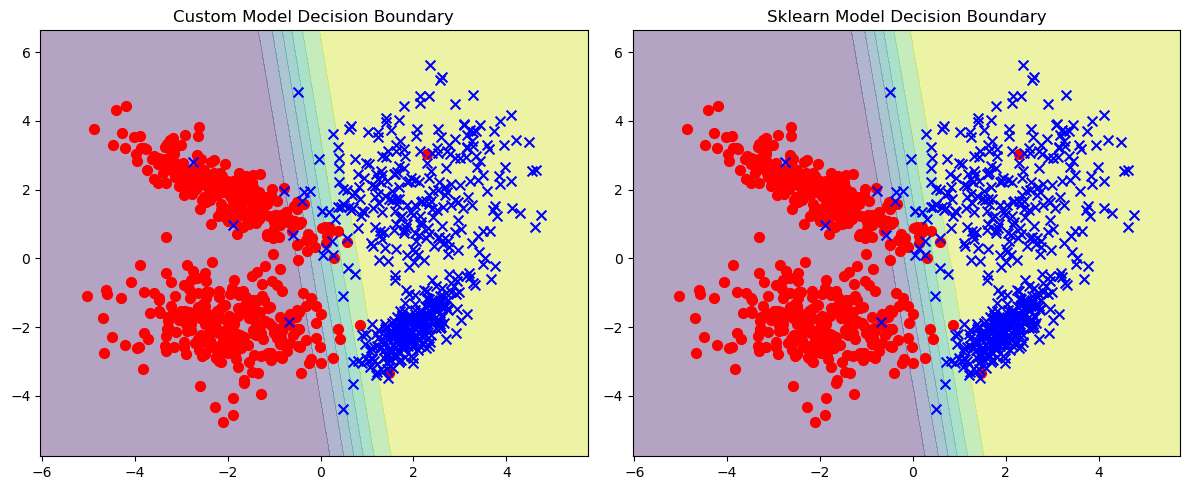

In [37]:
def plot_decision_boundary(X, y, custom_model, sklearn_model):
    plt.figure(figsize=(12, 5))
    
    # Custom model plot
    plt.subplot(1, 2, 1)
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 100))
    Z = custom_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", c='r', s=50)
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="x", c='b', s=50)
    plt.title("Custom Model Decision Boundary")
    
    # Sklearn model plot
    plt.subplot(1, 2, 2)
    Z = sklearn_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", c='r', s=50)
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="x", c='b', s=50)
    plt.title("Sklearn Model Decision Boundary")
    
    plt.tight_layout()
    plt.show()

plot_decision_boundary(X, y, custom_model, sklearn_model)

## 5. Эксперименты с разными значениями class_sep

Testing different class_sep values:


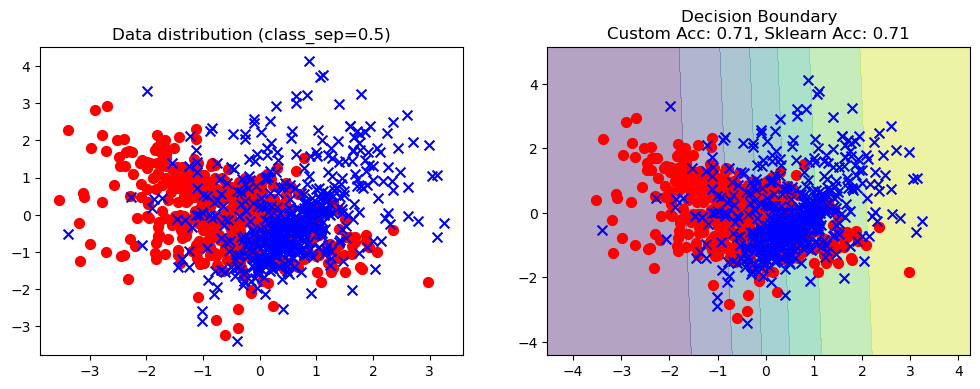

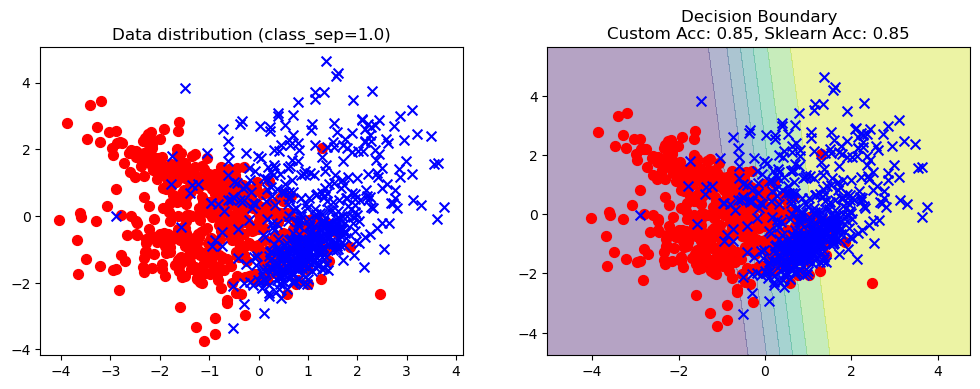

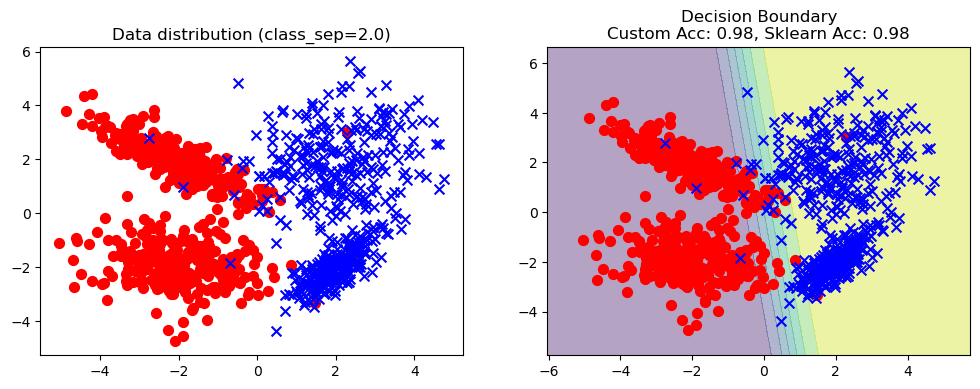

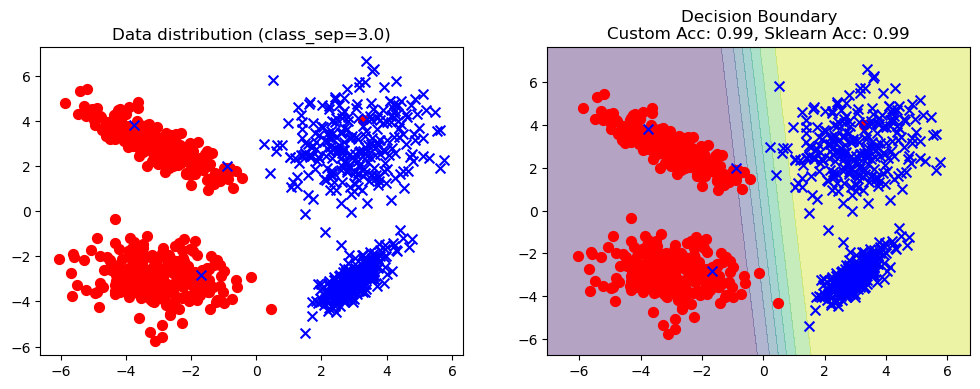

In [40]:
def test_class_sep_values(sep_values=[0.5, 1.0, 2.0, 3.0]):
    for sep in sep_values:
        X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                                 n_redundant=0, n_classes=2, class_sep=sep,
                                 random_state=1)
        
        # Обучение моделей
        custom_model = LogReg(alpha=0.1, n_iters=1000)
        custom_model.fit(X, y)
        y_pred_custom = custom_model.predict(X)
        
        sklearn_model = LogisticRegression()
        sklearn_model.fit(X, y)
        y_pred_sklearn = sklearn_model.predict(X)
        
        # Визуализация
        plt.figure(figsize=(12, 4))
        
        # Распределение данных
        plt.subplot(1, 2, 1)
        plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", c='r', s=50)
        plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="x", c='b', s=50)
        plt.title(f"Data distribution (class_sep={sep})")
        
        # Граница решения
        xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100),
                             np.linspace(X[:,1].min()-1, X[:,1].max()+1, 100))
        Z = custom_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.subplot(1, 2, 2)
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", c='r', s=50)
        plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="x", c='b', s=50)
        plt.title(f"Decision Boundary\nCustom Acc: {accuracy_score(y, y_pred_custom):.2f}, Sklearn Acc: {accuracy_score(y, y_pred_sklearn):.2f}")
        plt.show()

print("Testing different class_sep values:")
test_class_sep_values()

## 6. Многоклассовая классификация

In [43]:
def multiclass_classification():
    # Генерация данных с 3 классами
    X, y = make_classification(n_samples=1000, n_features=4, n_informative=4,
                             n_redundant=0, n_classes=3, n_clusters_per_class=1,
                             random_state=1)
    
    # One-vs-Rest с кастомной моделью
    models = []
    for class_label in np.unique(y):
        y_binary = (y == class_label).astype(int)
        model = LogReg(alpha=0.1, n_iters=1000)
        model.fit(X, y_binary)
        models.append(model)
    
    # Предсказание
    probas = np.array([model.predict_proba(X) for model in models]).T
    y_pred_custom = np.argmax(probas, axis=1)
    
    # Sklearn реализация
    sklearn_model = OneVsRestClassifier(LogisticRegression())
    sklearn_model.fit(X, y)
    y_pred_sklearn = sklearn_model.predict(X)
    
    print("Custom Model Accuracy:", accuracy_score(y, y_pred_custom))
    print("Sklearn Model Accuracy:", accuracy_score(y, y_pred_sklearn))

print("Multiclass classification:")
multiclass_classification()

Multiclass classification:
Custom Model Accuracy: 0.865
Sklearn Model Accuracy: 0.867
